#X CHEST-RAY PNEUMONIA DETECTION

Cet ensemble de données contient 5 856 images validées de radiographie thoracique. Les images sont divisées en un ensemble d'entraînement et un ensemble de tests et validation de patients indépendants. Les images sont étiquetées comme ( NORMALE/PNEUMONIA).

Ces données seront utiles pour développer/entraîner/tester des modèles de classification avec des techniques de Deep Learning.

#Importation des librairies

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,confusion_matrix

import os
import csv
import json
import shutil
import zipfile
from random import sample

import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications import MobileNet

from keras.models import Model
from keras.optimizers import SGD
from keras.models import load_model
from keras.models import Sequential
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.utils.vis_utils import plot_model
from tensorflow.keras.applications import MobileNetV2
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, GlobalAveragePooling2D, MaxPooling2D,Conv2D, BatchNormalization


#Téléchargement du Dataset

In [ ]:
os.environ['KAGGLE_CONFIG_DIR']='/content'
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:30<00:00, 56.9MB/s]
100% 2.29G/2.29G [00:30<00:00, 80.2MB/s]


##Extraction du Dataset

In [ ]:
with zipfile.ZipFile('chest-xray-pneumonia.zip', 'r') as zf:
  zf.extractall()

##Lecture du dataset

In [ ]:
img_path = os.path.join(os.getcwd(), 'chest_xray')
test_img_path = os.path.join(img_path, 'test')
train_img_path = os.path.join(img_path, 'train')
val_img_path = os.path.join(img_path, 'val')

##Connaître la répartition actuelle du dataset


In [ ]:
train_samp_nor = len(os.listdir(os.path.join(train_img_path, 'NORMAL')))
train_samp_pneu = len(os.listdir(os.path.join(train_img_path, 'PNEUMONIA')))
train_samp = train_samp_nor + train_samp_pneu

test_samp_nor = len(os.listdir(os.path.join(test_img_path, 'NORMAL')))
test_samp_pneu = len(os.listdir(os.path.join(test_img_path, 'PNEUMONIA')))
test_samp = test_samp_nor + test_samp_pneu

valid_samp_nor = len(os.listdir(os.path.join(val_img_path, 'NORMAL')))
valid_samp_pneu = len(os.listdir(os.path.join(val_img_path, 'PNEUMONIA')))
valid_samp = valid_samp_nor + valid_samp_pneu

all_samp = train_samp + test_samp + valid_samp

print ('Number of the train samples is :', train_samp)
print ('Number of the test samples is :', test_samp)
print ('Number of the validation samples is :', valid_samp)
print ('Number of the all samples is :', all_samp)

Number of the train samples is : 5216
Number of the test samples is : 624
Number of the validation samples is : 16
Number of the all samples is : 5856


Notre échantillon validation est trop petit (même pas 1% du total) et ça va provoquer un problème  d'entrainement.

Nous allons restructurer notre data en augmentant le nombre des images de validation à peut près de 10% et répartir notre dataset en 80% train, 10% test et ~10% validation

##Augmentation du nombre des images de validation

In [ ]:
# On va compter le nombre d’échantillons à déplacer afin que la partition d’apprentissage ~ 80%
train_part = train_samp/all_samp
n_to_move = round((train_part - 0.8) * train_samp)

# On va compter chaque normal et pneumonia échantillons à déplacer

n_to_move_nor = round((train_samp_nor + valid_samp_nor) /
                    (train_samp + valid_samp) * n_to_move)
n_to_move_pneu = n_to_move - n_to_move_nor

# on va déplacer les fichiers d’un répertoire vers un autre 
def move_files_random(from_dir, to_dir, n):
  for filename in sample(os.listdir(from_dir), k=n):
    from_fpath = os.path.join(from_dir, filename)
    to_fpath = os.path.join(to_dir, filename)
    shutil.move(from_fpath, to_fpath)
  display(f"move {n} files from {from_dir} to {to_dir}")

move_files_random(from_dir=os.path.join(train_img_path, 'NORMAL'),
                  to_dir=os.path.join(val_img_path, 'NORMAL'),
                  n=n_to_move_nor)

move_files_random(from_dir=os.path.join(train_img_path, 'PNEUMONIA'),
                  to_dir=os.path.join(val_img_path, 'PNEUMONIA'),
                  n=n_to_move_pneu)

'move 122 files from /content/chest_xray/train/NORMAL to /content/chest_xray/val/NORMAL'

'move 351 files from /content/chest_xray/train/PNEUMONIA to /content/chest_xray/val/PNEUMONIA'

## NOUVELLE RÉPARTITION DU DATASET

In [ ]:
train_samp_nor = len(os.listdir(os.path.join(train_img_path, 'NORMAL')))
train_samp_pneu = len(os.listdir(os.path.join(train_img_path, 'PNEUMONIA')))
train_samp = train_samp_nor + train_samp_pneu

test_samp_nor = len(os.listdir(os.path.join(test_img_path, 'NORMAL')))
test_samp_pneu = len(os.listdir(os.path.join(test_img_path, 'PNEUMONIA')))
test_samp = test_samp_nor + test_samp_pneu

valid_samp_nor = len(os.listdir(os.path.join(val_img_path, 'NORMAL')))
valid_samp_pneu = len(os.listdir(os.path.join(val_img_path, 'PNEUMONIA')))
valid_samp = valid_samp_nor + valid_samp_pneu

all_samp = train_samp + test_samp + valid_samp

print ('Number of the new train samples is :', train_samp)
print ('Number of the test samples is :', test_samp)
print ('Number of the new validation samples is :', valid_samp)
print ('Number of the total samples is :', all_samp)

Number of the new train samples is : 4743
Number of the test samples is : 624
Number of the new validation samples is : 489
Number of the total samples is : 5856


on peut clairement voir que notre validation est passée de 16 à 489 images et notre train est passé de 5216 à 4743 ce qui va permettre le bon déroulement de la phase training pour notre modèle

#Data Visualization

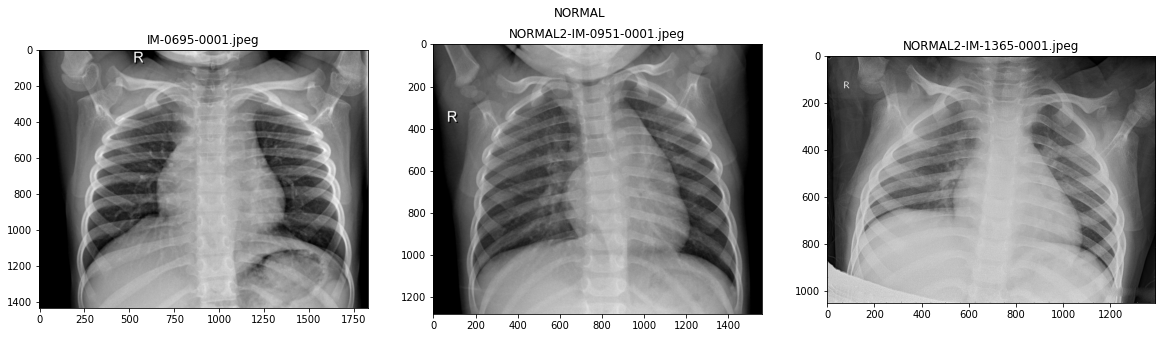

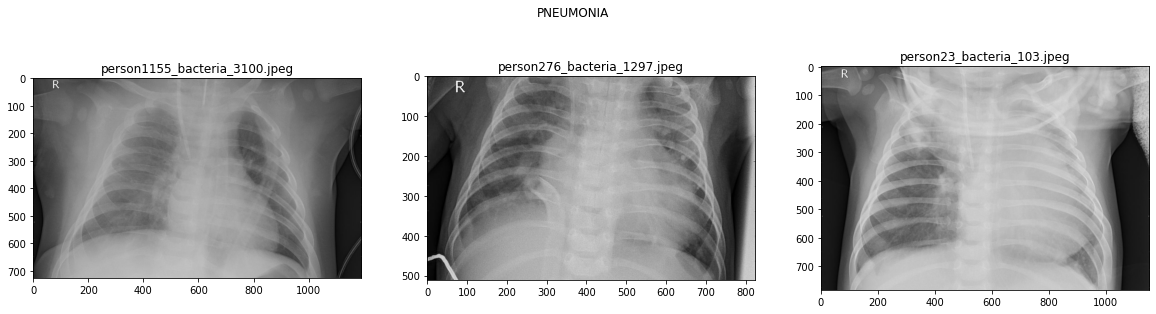

In [ ]:
img_normal = []
img_pneumonia = []
for img_path in [test_img_path, train_img_path, val_img_path]:
  for dirname, _, filenames in os.walk(os.path.join(img_path, 'NORMAL')):
    for filename in filenames:
        img_normal.append(os.path.join(dirname, filename))
  for dirname, _, filenames in os.walk(os.path.join(img_path, 'PNEUMONIA')):
    for filename in filenames:
        img_pneumonia.append(os.path.join(dirname, filename))

fig, ax = plt.subplots(1,3, figsize=(20, 5))
ax = ax.flatten()
plt.suptitle("NORMAL")
for i, j in enumerate(np.random.randint(len(img_normal), size=3).tolist()):
  ax[i].imshow(load_img(img_normal[j]))
  ax[i].set_title(img_normal[j].split('/')[-1]);

fig, ax = plt.subplots(1,3, figsize=(20, 5))
ax = ax.flatten()
plt.suptitle("PNEUMONIA")
for i, j in enumerate(np.random.randint(len(img_pneumonia), size=3).tolist()):
  ax[i].imshow(load_img(img_pneumonia[j]))
  ax[i].set_title(img_pneumonia[j].split('/')[-1]);

#Data augmentation

In [ ]:
epochs = 20 #@param {type:"slider", min:5, max:30, step:1}
batch_size =  32#@param {type:"number"}

In [ ]:
img_width, img_height= 240, 240

train_datagen = ImageDataGenerator(
                   rescale=1./255,
                   rotation_range=8,  
                   zoom_range=0.1,
                   width_shift_range=0.08,  
                   height_shift_range=0.08,  
                   horizontal_flip=False,
                   vertical_flip=False,
                   shear_range=0.02,
                   )
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
                                   train_img_path,
                                   target_size=(img_width, img_height),
                                   batch_size=batch_size,
                                   class_mode='binary',
                                   )

test_generator = test_datagen.flow_from_directory(
                                test_img_path,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                shuffle=False,
                                class_mode='binary',
                                )
val_generator = val_datagen.flow_from_directory(
                                val_img_path,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='binary',
                                )

Found 4743 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 489 images belonging to 2 classes.


#Construction du modèle

In [ ]:
optimizer = "adam" #@param ["adam", "RMSprop"]
learning_rate = 0.0001 #@param {type:"number"}

optimizer = Adam(learning_rate=learning_rate) if optimizer == "adam" \
              else RMSprop(learning_rate=learning_rate)

###Pour ce projet, on va utiliser 3 modèle et en choisir celui qui aura un accuracy le  plus élevé :

1.   Modèle CNN ;
2.   Modèle VGG16 via la technique transfer learning ;
3.   Modèle MobileNet aussi via la technique du transfer learning





#CNN Model

In [ ]:
input_shape=(img_width, img_height, 3)

img_input = Input(shape=input_shape, name='img_input')

x=Conv2D(32, (3,3), padding='same', activation='relu', name='layer1') (img_input)

x=Conv2D(64, (3,3), padding='same', activation='relu', name='layer2') (x)
x=MaxPooling2D((2,2), strides=(2,2), name='layer3')(x)
x=Dropout(0.25)(x)

x=Conv2D(64, (3,3), padding='same', activation='relu', name='layer4') (x)
x=MaxPooling2D((2,2), strides=(2,2), name='layer5')(x)
x=Dropout(0.25)(x)

x=Conv2D(128, (3,3), padding='same', activation='relu', name='layer6') (x)
x=MaxPooling2D((2,2), strides=(2,2), name='layer7')(x)
x=Dropout(0.25)(x)  

x=Flatten(name='layer_8')(x)
x=Dense(64, name='layer_9')(x)
x=Dropout(0.5)(x)  

x=Dense(1, activation='sigmoid', name='predictions')(x)


model_cnn=Model(inputs=img_input, outputs=x, name='CNN_PNEUMONIA')

model_cnn.summary()

Model: "CNN_PNEUMONIA"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_input (InputLayer)       [(None, 240, 240, 3)]     0         
_________________________________________________________________
layer1 (Conv2D)              (None, 240, 240, 32)      896       
_________________________________________________________________
layer2 (Conv2D)              (None, 240, 240, 64)      18496     
_________________________________________________________________
layer3 (MaxPooling2D)        (None, 120, 120, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 120, 120, 64)      0         
_________________________________________________________________
layer4 (Conv2D)              (None, 120, 120, 64)      36928     
_________________________________________________________________
layer5 (MaxPooling2D)        (None, 60, 60, 64)      

In [ ]:
loss = 'binary_crossentropy'
metrics = ['accuracy']

model_cnn.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

history = model_cnn.fit_generator(
                      train_generator,
                      epochs=epochs,
                      validation_data=val_generator,
                      )

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
149/149 [==============================] - 149s 692ms/step - loss: 0.6337 - accuracy: 0.7086 - val_loss: 0.3281 - val_accuracy: 0.8569
Epoch 2/20
149/149 [==============================] - 102s 683ms/step - loss: 0.2839 - accuracy: 0.8807 - val_loss: 0.1517 - val_accuracy: 0.9509
Epoch 3/20
149/149 [==============================] - 102s 683ms/step - loss: 0.1942 - accuracy: 0.9188 - val_loss: 0.1458 - val_accuracy: 0.9489
Epoch 4/20
149/149 [==============================] - 101s 679ms/step - loss: 0.2014 - accuracy: 0.9216 - val_loss: 0.1351 - val_accuracy: 0.9468
Epoch 5/20
149/149 [==============================] - 102s 681ms/step - loss: 0.1771 - accuracy: 0.9304 - val_loss: 0.1309 - val_accuracy: 0.9489
Epoch 6/20
149/149 [==============================] - 102s 681ms/step - loss: 0.1907 - accuracy: 0.9275 - val_loss: 0.1324 - val_accuracy: 0.9509
Epoch 7/20
149/149 [==============================] - 101s 678ms/step - loss: 0.1713 - accuracy: 0.9380 - val_loss: 0.1479 -

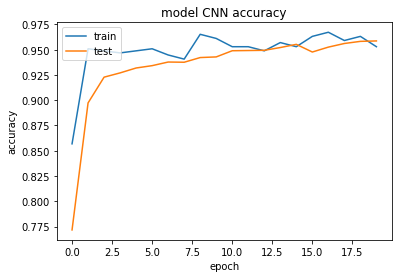

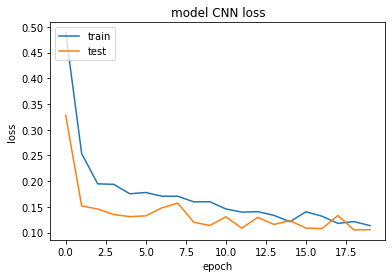

In [ ]:
plt.plot(model_cnn.history.history['val_accuracy'])
plt.plot(model_cnn.history.history['accuracy'])
plt.title('model CNN accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(model_cnn.history.history['loss'])
plt.plot(model_cnn.history.history['val_loss'])
plt.title('model CNN loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
test_loss_cnn, test_acc_cnn = model_cnn.evaluate(val_generator, verbose=2)
print('\nTest accuracy:', test_acc_cnn *100, '%')

16/16 - 5s - loss: 0.1056 - accuracy: 0.9530

Test accuracy: 95.2965259552002 %


In [ ]:
preds_cnn = model_cnn.predict(val_datagen.flow_from_directory(
                                val_img_path,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                shuffle=False,
                                class_mode='binary'
                                ),
                      steps=valid_samp//32+1)

labels = np.vstack([np.zeros(shape=(valid_samp_nor,1)),
                    np.ones(shape=(valid_samp_pneu,1))])
predictions_cnn = preds_cnn.reshape(1,-1)[0]
print(classification_report(labels.flatten(), np.round(preds_cnn).flatten(), target_names = ['NORMAL (Class 0)','PNEUMONIA (Class 1)']))

Found 489 images belonging to 2 classes.
                     precision    recall  f1-score   support

   NORMAL (Class 0)       0.90      0.93      0.91       130
PNEUMONIA (Class 1)       0.97      0.96      0.97       359

           accuracy                           0.95       489
          macro avg       0.94      0.95      0.94       489
       weighted avg       0.95      0.95      0.95       489



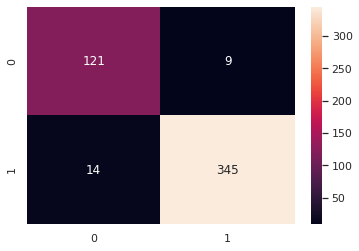

In [ ]:
sns.set(style='whitegrid')

# Get the confusion matrix
cm_cnn  = tf.math.confusion_matrix(labels.flatten(), np.round(preds_cnn).flatten())
ax = sns.heatmap(cm_cnn.numpy(), annot=True, fmt="d")

In [ ]:
model_cnn.save('chestxray_cnn_model.h5')

###Notre accuracy est de 95.29%, un très bon résultats pour un dataset faible en images, aussi en ramarque que le CNN modèle arrive à prédir la classe Normal à 90% et la classe Pneumonia à 97%.

##VGG16

In [ ]:
inputs = tf.keras.Input(shape=(img_width, img_height, 3))
preprocess = tf.keras.applications.vgg16.preprocess_input(inputs)
upscale = tf.keras.layers.Lambda(lambda x : tf.image.resize_with_pad(x,
                                                                     img_width,
                                                                     img_height,
                                                                     method = tf.image.ResizeMethod.BILINEAR))(inputs)

vgg16_model = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=(upscale),
    input_shape= (img_width, img_height, 3)
)

vgg16_model.trainable = False

In [ ]:
xx = vgg16_model.output
xx = tf.keras.layers.GlobalAveragePooling2D()(xx)
xx = tf.keras.layers.BatchNormalization()(xx)
xx = tf.keras.layers.Dense(256, activation='relu')(xx)
xx = layers.Dropout(0.2)(xx)
xx = tf.keras.layers.BatchNormalization()(xx)
xx = tf.keras.layers.Dense(128, activation='relu')(xx)
xx = layers.Dropout(0.2)(xx)
predictionsVgg16 = keras.layers.Dense(1, activation='sigmoid')(xx)

model_vgg16 = keras.Model(inputs, outputs = predictionsVgg16, name='VGG16_PNEUMONIA')

model_vgg16.summary()

Model: "VGG16_PNEUMONIA"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 240, 240, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 240, 240, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 240, 240, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 120, 120, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 120, 120, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 120, 120, 128) 

In [ ]:
model_vgg16.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

history = model_vgg16.fit_generator(
                      train_generator,
                      epochs=epochs,
                      validation_data=val_generator,
                      )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
149/149 [==============================] - 116s 720ms/step - loss: 0.2285 - accuracy: 0.9007 - val_loss: 0.4480 - val_accuracy: 0.7362
Epoch 2/20
149/149 [==============================] - 103s 688ms/step - loss: 0.1390 - accuracy: 0.9483 - val_loss: 0.2250 - val_accuracy: 0.9550
Epoch 3/20
149/149 [==============================] - 103s 693ms/step - loss: 0.1387 - accuracy: 0.9454 - val_loss: 0.1429 - val_accuracy: 0.9652
Epoch 4/20
149/149 [==============================] - 103s 691ms/step - loss: 0.1189 - accuracy: 0.9517 - val_loss: 0.1195 - val_accuracy: 0.9530
Epoch 5/20
149/149 [==============================] - 105s 705ms/step - loss: 0.1087 - accuracy: 0.9583 - val_loss: 0.1181 - val_accuracy: 0.9591
Epoch 6/20
149/149 [==============================] - 103s 693ms/step - loss: 0.1135 - accuracy: 0.9557 - val_loss: 0.1029 - val_accuracy: 0.9591
Epoch 7/20
149/149 [==============================] - 103s 690ms/step - loss: 0.1060 - accuracy: 0.9589 - val_loss: 0.1115 -

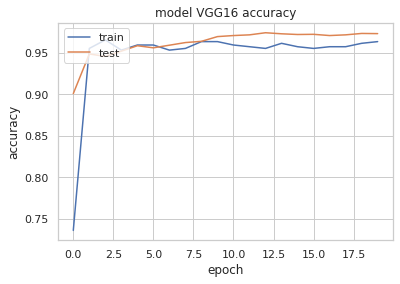

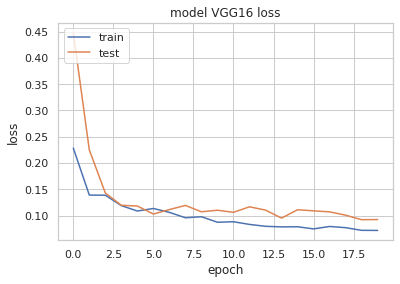

In [ ]:
plt.plot(model_vgg16.history.history['val_accuracy'])
plt.plot(model_vgg16.history.history['accuracy'])
plt.title('model VGG16 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(model_vgg16.history.history['loss'])
plt.plot(model_vgg16.history.history['val_loss'])
plt.title('model VGG16 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
test_loss_vgg16, test_acc_vgg16 = model_vgg16.evaluate(val_generator, verbose=2)
print('\nTest accuracy:', test_acc_vgg16 *100, '%')

16/16 - 6s - loss: 0.0924 - accuracy: 0.9632

Test accuracy: 96.31901979446411 %


In [ ]:
preds_vgg16 = model_vgg16.predict(val_datagen.flow_from_directory(
                                val_img_path,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                shuffle=False,
                                class_mode='binary'
                                ),
                      steps=valid_samp//32+1)

labels = np.vstack([np.zeros(shape=(valid_samp_nor,1)),
                    np.ones(shape=(valid_samp_pneu,1))])
predictions_vgg16 = preds_vgg16.reshape(1,-1)[0]
print(classification_report(labels.flatten(), np.round(preds_vgg16).flatten(), target_names = ['NORMAL (Class 0)','PNEUMONIA (Class 1)']))

Found 489 images belonging to 2 classes.
                     precision    recall  f1-score   support

   NORMAL (Class 0)       0.89      0.98      0.93       130
PNEUMONIA (Class 1)       0.99      0.96      0.97       359

           accuracy                           0.96       489
          macro avg       0.94      0.97      0.95       489
       weighted avg       0.97      0.96      0.96       489



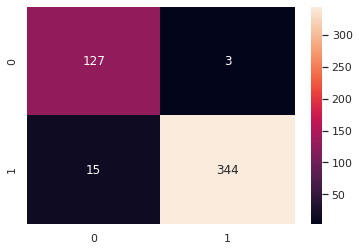

In [ ]:
sns.set(style='whitegrid')

# Get the confusion matrix
cm_vgg16  = tf.math.confusion_matrix(labels.flatten(), np.round(preds_vgg16).flatten())
ax = sns.heatmap(cm_vgg16.numpy(), annot=True, fmt="d")

In [ ]:
model_vgg16.save('chestxray_vgg16_model.h5')

###Notre accuracy est de 96.31%, un résultat meilleur que celui du CNN modèle, aussi en ramarque que le vgg16 modèle arrive à prédir la classe Normal à 89% et la classe Pneumonia à 99%.

##MOBILENET

In [ ]:
inputs = tf.keras.Input(shape=(img_width, img_height, 3))
preprocess = tf.keras.applications.mobilenet.preprocess_input(inputs)
upscale = tf.keras.layers.Lambda(lambda x : tf.image.resize_with_pad(x,
                                                                     img_width,
                                                                     img_height,
                                                                     method = tf.image.ResizeMethod.BILINEAR))(inputs)

mobilenet_model = tf.keras.applications.MobileNet(
    include_top=False,
    weights="imagenet",
    input_tensor=(upscale),
    input_shape= (img_width, img_height, 3)
)

mobilenet_model.trainable = False

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
for layer in mobilenet_model.layers:
      layer.trainable =  False # freezing densenet layers 


xxx = mobilenet_model.output
xxx = tf.keras.layers.GlobalAveragePooling2D()(xxx)
xxx = tf.keras.layers.BatchNormalization()(xxx)
xxx = tf.keras.layers.Dense(256, activation='relu')(xxx)
xxx = layers.Dropout(0.2)(xxx)
xxx = tf.keras.layers.BatchNormalization()(xxx)
xxx = tf.keras.layers.Dense(128, activation='relu')(xxx)
xxx = layers.Dropout(0.2)(xxx)
predictions_mobilenet = keras.layers.Dense(1, activation='sigmoid')(xxx)

model_mobilenet = keras.Model(inputs, outputs = predictions_mobilenet, name='MOBILENET_PNEUMONIA')

model_mobilenet.summary()

Model: "MOBILENET_PNEUMONIA"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
lambda_4 (Lambda)            (None, 240, 240, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 120, 120, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 120, 120, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 120, 120, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 120, 120, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 120, 120, 3

In [ ]:
model_mobilenet.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

history = model_mobilenet.fit_generator(
                      train_generator,
                      epochs=epochs,
                      validation_data=val_generator,
                      )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
149/149 [==============================] - 101s 663ms/step - loss: 0.1782 - accuracy: 0.9285 - val_loss: 0.1022 - val_accuracy: 0.9775
Epoch 2/20
149/149 [==============================] - 96s 647ms/step - loss: 0.1036 - accuracy: 0.9597 - val_loss: 0.0768 - val_accuracy: 0.9734
Epoch 3/20
149/149 [==============================] - 97s 650ms/step - loss: 0.0861 - accuracy: 0.9688 - val_loss: 0.0675 - val_accuracy: 0.9734
Epoch 4/20
149/149 [==============================] - 97s 649ms/step - loss: 0.0852 - accuracy: 0.9684 - val_loss: 0.0650 - val_accuracy: 0.9755
Epoch 5/20
149/149 [==============================] - 99s 664ms/step - loss: 0.0706 - accuracy: 0.9755 - val_loss: 0.0683 - val_accuracy: 0.9693
Epoch 6/20
149/149 [==============================] - 98s 659ms/step - loss: 0.0754 - accuracy: 0.9717 - val_loss: 0.0637 - val_accuracy: 0.9755
Epoch 7/20
149/149 [==============================] - 97s 651ms/step - loss: 0.0682 - accuracy: 0.9736 - val_loss: 0.0788 - val_a

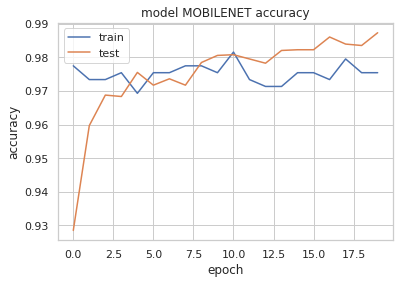

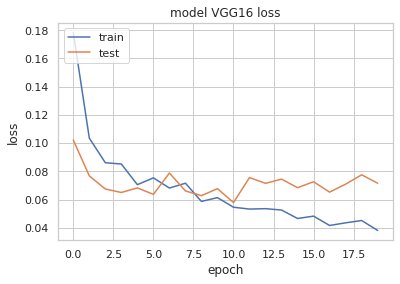

In [ ]:
plt.plot(model_mobilenet.history.history['val_accuracy'])
plt.plot(model_mobilenet.history.history['accuracy'])
plt.title('model MOBILENET accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(model_mobilenet.history.history['loss'])
plt.plot(model_mobilenet.history.history['val_loss'])
plt.title('model VGG16 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
test_loss_mobilenet, test_acc_mobilenet = model_mobilenet.evaluate(val_generator, verbose=2)
print('\nTest accuracy:', test_acc_mobilenet *100, '%')

16/16 - 5s - loss: 0.0716 - accuracy: 0.9755

Test accuracy: 97.54601120948792 %


In [ ]:
preds_mobilenet = model_mobilenet.predict(val_datagen.flow_from_directory(
                                val_img_path,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                shuffle=False,
                                class_mode='binary'
                                ),
                      steps=valid_samp//32+1)

labels = np.vstack([np.zeros(shape=(valid_samp_nor,1)),
                    np.ones(shape=(valid_samp_pneu,1))])
predictions_mobileNet = preds_mobilenet.reshape(1,-1)[0]
print(classification_report(labels.flatten(), np.round(preds_mobilenet).flatten(), target_names = ['NORMAL (Class 0)','PNEUMONIA (Class 1)']))

Found 489 images belonging to 2 classes.
                     precision    recall  f1-score   support

   NORMAL (Class 0)       0.92      0.99      0.96       130
PNEUMONIA (Class 1)       1.00      0.97      0.98       359

           accuracy                           0.98       489
          macro avg       0.96      0.98      0.97       489
       weighted avg       0.98      0.98      0.98       489



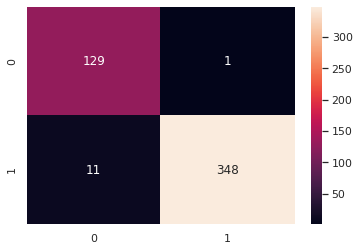

In [ ]:
sns.set(style='whitegrid')

# Get the confusion matrix
cm_mobilenet  = tf.math.confusion_matrix(labels.flatten(), np.round(preds_mobilenet).flatten())
ax = sns.heatmap(cm_mobilenet.numpy(), annot=True, fmt="d")

In [ ]:
model_mobilenet.save('chestxray_mobilenet_model.h5')

###Notre accuracy est de 97.54%, meuilleur résultat que celui des deux modèle précédents, MobileNet modèle arrive à prédir la classe Normal à 92% et la classe Pneumonia à 100%.

#Récap

In [ ]:
print('\nCNN Test accuracy :', test_acc_cnn *100, '%')
print('\nVGG16 Test accuracy :', test_acc_vgg16 *100, '%')
print('\nMOBILNET Test accuracy:', test_acc_mobilenet *100, '%')


CNN Test accuracy : 95.2965259552002 %

VGG16 Test accuracy : 96.31901979446411 %

MOBILNET Test accuracy: 97.54601120948792 %


In [ ]:
print('Classification CNN Report :', classification_report(labels.flatten(), np.round(preds_cnn).flatten(), target_names = ['NORMAL (Class 0)','PNEUMONIA (Class 1)']))
print('Classification VGG16 Report :',classification_report(labels.flatten(), np.round(preds_vgg16).flatten(), target_names = ['NORMAL (Class 0)','PNEUMONIA (Class 1)']))
print('Classification MOBILENET Report :',classification_report(labels.flatten(), np.round(preds_mobilenet).flatten(), target_names = ['NORMAL (Class 0)','PNEUMONIA (Class 1)']))

Classification CNN Report :                      precision    recall  f1-score   support

   NORMAL (Class 0)       0.90      0.93      0.91       130
PNEUMONIA (Class 1)       0.97      0.96      0.97       359

           accuracy                           0.95       489
          macro avg       0.94      0.95      0.94       489
       weighted avg       0.95      0.95      0.95       489

Classification VGG16 Report :                      precision    recall  f1-score   support

   NORMAL (Class 0)       0.89      0.98      0.93       130
PNEUMONIA (Class 1)       0.99      0.96      0.97       359

           accuracy                           0.96       489
          macro avg       0.94      0.97      0.95       489
       weighted avg       0.97      0.96      0.96       489

Classification MOBILENET Report :                      precision    recall  f1-score   support

   NORMAL (Class 0)       0.92      0.99      0.96       130
PNEUMONIA (Class 1)       1.00      0.97      0

#Le meilleur modèle pour la détection de la pneumonie est le MOBILNET avec une précision de presque 98%